In [300]:

import pandas as pd

In [301]:
from openpyxl import load_workbook

def obtener_filas_con_fuente_roja(path_excel: str, nombre_hoja: str) -> list:
    wb = load_workbook(filename=path_excel, data_only=True)
    ws = wb[nombre_hoja]

    filas_rojas = []

    for i, row in enumerate(ws.iter_rows(), start=0):  # 0-based para que coincida con df sin header
        for cell in row:
            if cell.font.color and cell.font.color.type == "rgb":
                if cell.font.color.rgb in ["FF0000", "FFFF0000"]:  # rojo
                    filas_rojas.append(i-1)
                    break
    return filas_rojas



In [302]:
def extraer_tabla_categorias(df: pd.DataFrame, path_excel: str, nombre_hoja: str) -> pd.DataFrame:
    """
    Extrae y limpia la tabla de resumen por categorías desde un DataFrame.
    Incluye 'Total', marca si es total y si la fila es roja en el Excel.
    """
    filas_rojas = obtener_filas_con_fuente_roja(path_excel, nombre_hoja)

    end_row = df[df.iloc[:, 0].astype(str).str.contains("Total", case=False, na=False)].index.min()
    tabla = df.iloc[:end_row + 1, [0, 1, 4, 5, 6, 18, 19, 21]].copy()
    tabla.columns = ["Categoría", "Recibidas", "Atendidas_num", "Atendidas_%", "Duracion",
                     "Desborde_cantidad", "Desborde_tiempo", "Abandonadas"]

    # Marcar fila 'Total'
    tabla["EsTotal"] = tabla["Categoría"].astype(str).str.contains("Total", case=False, na=False)

    # Marcar si es roja según openpyxl (usamos índice original)
    tabla["EsRoja"] = df.index[tabla.index].isin(filas_rojas)


    # Filtrar solo las que tienen % válido
    tabla = tabla[tabla["Atendidas_%"].astype(str).str.contains("%", na=False)]

    # Limpiar y convertir valores
    tabla["Atendidas_%"] = (
        tabla["Atendidas_%"].astype(str)
        .str.replace(",", ".")
        .str.replace(" %", "", regex=False)
        .astype(float)
    )

    return tabla.reset_index(drop=True)



In [303]:
excel_path = "data/INFORME DE LLAMADAS AUTOCLIMA ABRIL 2025.xlsx"
sheet_name = "ABRIL"

df_ABRIL = pd.read_excel(excel_path, sheet_name="ABRIL")
df_MARZO = pd.read_excel(excel_path, sheet_name="MARZO")
df_FEBRERO = pd.read_excel(excel_path, sheet_name="FEBRERO")
df_ENERO = pd.read_excel(excel_path, sheet_name="ENERO")
# Extraer tablas de categorías para cada mes
categorias_df = extraer_tabla_categorias(df_ABRIL, path_excel=excel_path, nombre_hoja="ABRIL")
categorias_anterior_df = extraer_tabla_categorias(df_MARZO, path_excel=excel_path, nombre_hoja="MARZO")
categorias_anterior_anterior_df = extraer_tabla_categorias(df_FEBRERO, path_excel=excel_path, nombre_hoja="FEBRERO")
categorias_anterior_anterior_anterior_df = extraer_tabla_categorias(df_ENERO, path_excel=excel_path, nombre_hoja="ENERO")

In [304]:
def extraer_tabla_dias(df: pd.DataFrame, path_excel: str, nombre_hoja: str) -> pd.DataFrame:
    """
    Extrae y limpia la tabla por día desde un DataFrame.
    Detecta si la fila está escrita en rojo, incluye columna EsTotal y limpia %.
    """
    filas_rojas = obtener_filas_con_fuente_roja(path_excel, nombre_hoja)

    # Buscar fila de inicio
    start_row = df[df.iloc[:, 0].astype(str).str.contains("Día", case=False, na=False)].index.min() + 1

    # Avanzar dinámicamente hasta que la columna 0 esté vacía (fin de la tabla)
    current_row = start_row
    while current_row < len(df) and pd.notna(df.iloc[current_row, 0]):
        current_row += 1

    # Extraer rango completo
    tabla = df.iloc[start_row:current_row, [0, 1, 2, 5, 6]].copy()
    tabla.columns = ["Dia", "Categoría", "Recibidas", "Atendidas_num", "Atendidas_%"]

    # Marcar total y filas en rojo
    tabla["EsTotal"] = tabla["Dia"].astype(str).str.contains("Total", case=False, na=False)
    tabla["EsRoja"] = tabla.index.isin(filas_rojas)

    # Limpiar porcentaje
    tabla = tabla[tabla["Atendidas_%"].astype(str).str.contains("%", na=False)]
    tabla["Atendidas_%"] = (
        tabla["Atendidas_%"]
        .astype(str)
        .str.replace(",", ".")
        .str.replace(" %", "", regex=False)
        .astype(float)
    )

    return tabla.reset_index(drop=True)



In [305]:
dias_df = extraer_tabla_dias(df, path_excel=excel_path, nombre_hoja=sheet_name)


In [306]:
def extraer_tabla_franjas(df: pd.DataFrame, path_excel: str, nombre_hoja: str) -> pd.DataFrame:
    """
    Extrae y limpia la tabla por franja horaria desde un DataFrame.
    Detecta si la fila está escrita en rojo, incluye columna EsTotal y limpia %.
    """
    filas_rojas = obtener_filas_con_fuente_roja(path_excel, nombre_hoja)

    # Buscar la fila de inicio (la última aparición de "Categoría")
    start_row = df[df.iloc[:, 0].astype(str).str.contains("Categoría", case=False, na=False)].index[-1] + 1

    # Buscar la fila de fin: la que contiene "Total" o el primer NaN en la columna 0
    current_row = start_row
    while current_row < len(df):
        valor = str(df.iloc[current_row, 0])
        if pd.isna(valor) or "total" in valor.lower():
            break
        current_row += 1

    # Extraer tabla
    tabla = df.iloc[start_row:current_row + 1, [0, 1, 4, 5]].copy()
    tabla.columns = ["Categoría", "Recibidas", "Atendidas_num", "Atendidas_%"]

    # Marcar total y filas rojas
    tabla["EsTotal"] = tabla["Categoría"].astype(str).str.contains("Total", case=False, na=False)
    tabla["EsRoja"] = tabla.index.isin(filas_rojas)

    # Limpiar porcentaje
    tabla = tabla[tabla["Atendidas_%"].astype(str).str.contains("%", na=False)]
    tabla["Atendidas_%"] = (
        tabla["Atendidas_%"]
        .astype(str)
        .str.replace(",", ".")
        .str.replace(" %", "", regex=False)
        .astype(float)
    )

    return tabla.reset_index(drop=True)


In [307]:
franjas_df = extraer_tabla_franjas(df, path_excel=excel_path, nombre_hoja=sheet_name)


In [308]:
def generar_correo_informe(
    nombre_destinatario: str,
    mes: str,
    año: int,
    fecha_inicio: str,
    fecha_fin: str,
    porcentaje_mes: float,
    porcentaje_mes_anterior: float,
    cumple_objetivo: bool,
    total_recibidas: int,
    total_no_atendidas: int,
    desbordadas: int,
    abandonadas: int,
    categorias_conflictivas: list,  # Lista de tuplas (nombre, porcentaje)
    tabla_categorias: str,
    resumen_dias_flojos: str,
    resumen_franjas_flojas: str,
) -> str:
    cumplimiento = "El porcentaje de atención al cliente es bajo, pues sigue sin llegar al mínimo aceptable de 85%." \
        if not cumple_objetivo else "El porcentaje de atención cumple con el objetivo mínimo del 85%."

    texto = f"""
El nivel de atención ha {'aumentado' if porcentaje_mes > porcentaje_mes_anterior else 'disminuido'} con un {porcentaje_mes:.2f}% versus al {porcentaje_mes_anterior:.2f}% del mes de {mes_anterior(mes)} de {año}. {cumplimiento}

Para visualizar mejor la evolución adjuntamos histórico de nivel de atención de lo que llevamos del año:

[GRÁFICO]

Informe de Colas:

Nos refleja que se han recibido un total de {total_recibidas} llamadas y no se han atendido {total_no_atendidas}.

De las {total_no_atendidas} llamadas que no han sido atendidas:

{desbordadas} llamadas han sido desbordadas por tiempo.
{abandonadas} llamadas han sido abandonadas.

Las colas que más han afectado al porcentaje de atención:
"""

    for cat, pct in categorias_conflictivas:
        texto += f"\n- {cat} con un {pct:.2f} %."

    texto += f"""

Copio cuadro para mayor visibilidad:

{tabla_categorias}

El informe por días, nos indica que los días más flojos de {mes.lower()}:

{resumen_dias_flojos}

El informe por franja horaria nos indica que las más afectadas son:

{resumen_franjas_flojas}
"""
    return texto

def mes_anterior(mes_actual: str) -> str:
    meses = [
        "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
        "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
    ]
    idx = meses.index(mes_actual.capitalize())
    return meses[idx - 1] if idx > 0 else meses[-1]

In [309]:
def sacar_variables_informe(
    categorias_df: pd.DataFrame,
    categorias_anterior_df: pd.DataFrame,
) -> tuple:
    total_recibidas = categorias_df[categorias_df["Categoría"] == "Total"]["Recibidas"].astype(int).iloc[0]
    total_no_atendidas = total_recibidas - categorias_df[categorias_df["Categoría"] == "Total"]["Atendidas_num"].astype(int).iloc[0]
    desbordadas = categorias_df[categorias_df["Categoría"] == "Total"]["Desborde_cantidad"].astype(int).iloc[0]
    abandonadas = categorias_df[categorias_df["Categoría"] == "Total"]["Abandonadas"].astype(int).iloc[0]

    porcentaje_mes = categorias_df[categorias_df["Categoría"] == "Total"]["Atendidas_%"].astype(float).iloc[0]
    porcentaje_mes_anterior = categorias_anterior_df[categorias_anterior_df["Categoría"] == "Total"]["Atendidas_%"].astype(float).iloc[0]

    cumple_objetivo = porcentaje_mes >= 85.0

    categorias_conflictivas = list(categorias_df[categorias_df["EsRoja"]][["Categoría", "Atendidas_%"]].itertuples(index=False, name=None))


    return (
        porcentaje_mes, porcentaje_mes_anterior, cumple_objetivo,
        total_recibidas, total_no_atendidas, desbordadas, abandonadas,
        categorias_conflictivas
    )

In [310]:
import matplotlib.pyplot as plt

In [311]:
def generar_grafico_meses_anteriores_barplot(
    categorias_df: pd.DataFrame,
    categorias_anterior_df: pd.DataFrame,
    categorias_anterior_anterior_df: pd.DataFrame,
    categorias_anterior_anterior_anterior_df: pd.DataFrame
) -> str:
    valores = [
        categorias_anterior_anterior_anterior_df[categorias_anterior_anterior_anterior_df["Categoría"] == "Total"]["Atendidas_%"].astype(float).iloc[0],
        categorias_anterior_anterior_df[categorias_anterior_anterior_df["Categoría"] == "Total"]["Atendidas_%"].astype(float).iloc[0],
        categorias_anterior_df[categorias_anterior_df["Categoría"] == "Total"]["Atendidas_%"].astype(float).iloc[0],
        categorias_df[categorias_df["Categoría"] == "Total"]["Atendidas_%"].astype(float).iloc[0]
    ]
    meses = ["Enero", "Febrero", "Marzo", "Abril"]

    colores = ['green' if v >= 85 else 'red' for v in valores]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(meses, valores, color=colores)
    plt.title("Estadísticas Año 2025")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Añadir etiquetas con los valores encima de cada barra
    for bar, val in zip(bars, valores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{val:.2f}%", 
                 ha='center', va='bottom', fontsize=10)

    plt.show()


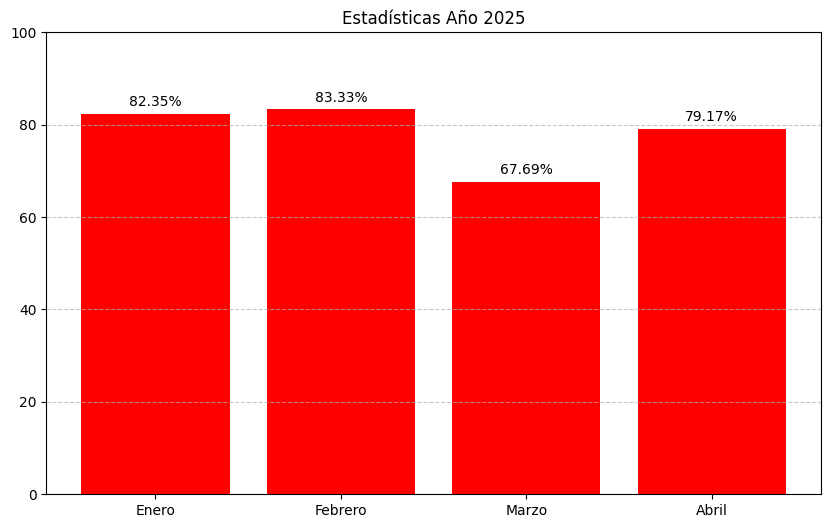

In [312]:
generar_grafico_meses_anteriores_barplot(
    categorias_df,
    categorias_anterior_df,
    categorias_anterior_anterior_df,
    categorias_anterior_anterior_anterior_df
)

In [313]:
import pandas as pd
import matplotlib.pyplot as plt

def generar_tabla_estilo_grid(df: pd.DataFrame) -> str:
    tabla = df.copy()
    tabla["Atendidas_%"] = tabla["Atendidas_%"].apply(lambda x: f"{x:.2f} %")

    columnas = ["Categoría", "Recibidas", "Atendidas_num", "Atendidas_%"]
    columnas_titulo = ["Categoría", "Recibidas | Número", "Atendidas | Número", "Atendidas | %"]
    table_data = tabla[columnas].values.tolist()

    # Ajustar tamaño de figura dinámicamente
    fig_height = 0.55 + 0.4 * len(tabla)
    fig = plt.figure(figsize=(8, fig_height))
    ax = fig.add_axes([0, 0, 1, 1])  # Ocupa todo el espacio
    ax.axis('off')

    table = ax.table(
        cellText=table_data,
        colLabels=columnas_titulo,
        cellLoc='center',
        loc='center'
    )

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_facecolor('#00BFFF')
            cell.set_text_props(weight='bold', color='white')
        else:
            is_roja = tabla["EsRoja"].iloc[row - 1]
            is_total = tabla["Categoría"].iloc[row - 1].strip().lower() == "total"
            if is_roja:
                cell.set_text_props(color='red')
            if is_total:
                cell.set_facecolor('#00BFFF')
                cell.set_text_props(weight='bold', color='white')

    # Guardar imagen sin márgenes blancos
    plt.show()



In [314]:
variables_informe = sacar_variables_informe(categorias_df, categorias_anterior_df)

In [315]:
variables_informe

(np.float64(79.17),
 np.float64(67.69),
 np.False_,
 np.int64(96),
 np.int64(20),
 np.int64(17),
 np.int64(3),
 [('Almacen', 76.19), ('Contabilidad', 52.63)])

In [316]:
correo = generar_correo_informe(
    nombre_destinatario="Carlos",
    mes="Abril",
    año=2025,
    fecha_inicio="01.04.2025",
    fecha_fin="30.04.2025",
    porcentaje_mes=variables_informe[0],
    porcentaje_mes_anterior=variables_informe[1],
    cumple_objetivo=variables_informe[2],
    total_recibidas=variables_informe[3],
    total_no_atendidas=variables_informe[4],
    desbordadas=variables_informe[5],
    abandonadas=variables_informe[6],
    categorias_conflictivas=variables_informe[7],
    tabla_categorias="[TABLA_CATEGORIAS]",
    resumen_dias_flojos="[TABLA_DIAS]",
    resumen_franjas_flojas="[TABLA_FRANJAS]"
)

print(correo)


El nivel de atención ha aumentado con un 79.17% versus al 67.69% del mes de Marzo de 2025. El porcentaje de atención al cliente es bajo, pues sigue sin llegar al mínimo aceptable de 85%.

Para visualizar mejor la evolución adjuntamos histórico de nivel de atención de lo que llevamos del año:

[GRÁFICO]

Informe de Colas:

Nos refleja que se han recibido un total de 96 llamadas y no se han atendido 20.

De las 20 llamadas que no han sido atendidas:

17 llamadas han sido desbordadas por tiempo.
3 llamadas han sido abandonadas.

Las colas que más han afectado al porcentaje de atención:

- Almacen con un 76.19 %.
- Contabilidad con un 52.63 %.

Copio cuadro para mayor visibilidad:

[TABLA_CATEGORIAS]

El informe por días, nos indica que los días más flojos de abril:

[TABLA_DIAS]

El informe por franja horaria nos indica que las más afectadas son:

[TABLA_FRANJAS]



In [317]:
def insertar_tabla_categorias(doc: Document, df: pd.DataFrame):
    doc.add_paragraph("Tabla resumen por categorías:")

    columnas = ["Categoría", "Recibidas", "Atendidas_num", "Atendidas_%"]
    columnas_titulo = ["Categoría", "Recibidas | Número", "Atendidas | Número", "Atendidas | %"]

    table = doc.add_table(rows=1, cols=len(columnas))
    table.style = 'Table Grid'
    hdr_cells = table.rows[0].cells
    for i, col in enumerate(columnas_titulo):
        hdr_cells[i].text = col

    for _, row in df.iterrows():
        row_cells = table.add_row().cells
        for i, col in enumerate(columnas):
            if col == "Atendidas_%":
                row_cells[i].text = f"{row[col]:.2f} %"
            else:
                row_cells[i].text = str(row[col])


In [318]:
from datetime import datetime

def insertar_tabla_dias(doc: Document, df: pd.DataFrame):

    columnas = ["Dia", "Categoría", "Recibidas", "Atendidas_num", "Atendidas_%"]
    columnas_titulo = ["Día", "Categoría", "Recibidas | Número", "Atendidas | Número", "Atendidas | %"]

    # Filtrar solo rojas
    df = df[df["EsRoja"]]

    # Normalizar fecha como texto tipo dd/mm/yy
    df = df.copy()
    df["Día_texto"] = df["Categoría"].apply(lambda x: pd.to_datetime(x).strftime("%d/%m/%y") if pd.notnull(x) else "")

    table = doc.add_table(rows=1, cols=len(columnas))
    table.style = 'Table Grid'

    hdr_cells = table.rows[0].cells
    for i, col in enumerate(columnas_titulo):
        hdr_cells[i].text = col

    for _, row in df.iterrows():
        row_cells = table.add_row().cells
        row_cells[0].text = row["Dia"]  # Día de la semana
        row_cells[1].text = row["Día_texto"]  # Fecha formateada
        row_cells[2].text = str(row["Recibidas"])
        row_cells[3].text = str(row["Atendidas_num"])
        row_cells[4].text = f"{row['Atendidas_%']:.2f} %"



In [319]:
def insertar_tabla_franjas(doc: Document, df: pd.DataFrame):

    columnas = ["Categoría", "Recibidas", "Atendidas_num", "Atendidas_%"]
    columnas_titulo = ["Categoría", "Recibidas | Número", "Atendidas | Número", "Atendidas | %"]

    # Filtrar solo filas rojas
    df = df[df["EsRoja"]].copy()

    table = doc.add_table(rows=1, cols=len(columnas))
    table.style = 'Table Grid'

    hdr_cells = table.rows[0].cells
    for i, col in enumerate(columnas_titulo):
        hdr_cells[i].text = col

    for _, row in df.iterrows():
        row_cells = table.add_row().cells
        for i, col in enumerate(columnas):
            if col == "Atendidas_%":
                row_cells[i].text = f"{row[col]:.2f} %"
            else:
                row_cells[i].text = str(row[col])

In [320]:
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx2pdf import convert
import pandas as pd
import os

def exportar_informe_word_y_pdf_por_bloques(
    texto_informe: str,
    path_word: str,
    tabla_categorias: pd.DataFrame,
    tabla_dias: pd.DataFrame,
    tabla_franjas: pd.DataFrame,
    imagen_grafico_path: str = None
) -> tuple:
    doc = Document()
    doc.add_heading("Informe de llamadas", level=1)

    lineas = texto_informe.strip().split("\n")

    for linea in lineas:
        linea = linea.strip()

        if not linea:
            continue

        if "[GRÁFICO]" in linea:
            if imagen_grafico_path:
                p = doc.add_paragraph()
                run = p.add_run()
                run.add_picture(imagen_grafico_path, width=Inches(5.5))
                p.alignment = WD_ALIGN_PARAGRAPH.CENTER

        elif "[TABLA_CATEGORIAS]" in linea:
            insertar_tabla_categorias(doc, tabla_categorias)

        elif "[TABLA_DIAS]" in linea:
            insertar_tabla_dias(doc, tabla_dias)

        elif "[TABLA_FRANJAS]" in linea:
            insertar_tabla_franjas(doc, tabla_franjas)

        else:
            doc.add_paragraph(linea)

    # Guardar .docx
    doc.save(path_word)

    # Convertir a PDF
    path_pdf = path_word.replace(".docx", ".pdf")
    convert(path_word, path_pdf)

    return path_word, path_pdf


In [321]:
texto = correo  # texto con [TABLA_CATEGORIAS], [TABLA_DIAS], [TABLA_FRANJAS], etc.

word_path, pdf_path = exportar_informe_word_y_pdf_por_bloques(
    texto_informe=texto,
    path_word="informe_llamadas_abril.docx",
    tabla_categorias=categorias_df,
    tabla_dias=dias_df,
    tabla_franjas=franjas_df,
    imagen_grafico_path="barplot.png"
)


100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


In [322]:
print(categorias_df.columns)
print(dias_df.columns)
print(franjas_df.columns)

Index(['Categoría', 'Recibidas', 'Atendidas_num', 'Atendidas_%', 'Duracion',
       'Desborde_cantidad', 'Desborde_tiempo', 'Abandonadas', 'EsTotal',
       'EsRoja'],
      dtype='object')
Index(['Dia', 'Categoría', 'Recibidas', 'Atendidas_num', 'Atendidas_%',
       'EsTotal', 'EsRoja'],
      dtype='object')
Index(['Categoría', 'Recibidas', 'Atendidas_num', 'Atendidas_%', 'EsTotal',
       'EsRoja'],
      dtype='object')
